# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega_{surf} + R_{diff,R2} \end{equation*}
## **SODA 3.4.2**

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(25)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [2]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.595912cbddc64475ba3eb77457688dbe Dashboard: /services/dask-gateway/clusters/prod.595912cbddc64475ba3eb77457688dbe/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
from fastjmd95 import jmd95numba
%matplotlib inline
xr.set_options(display_style='text');

In [4]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem()
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True, decode_times=False)

In [5]:
path = 'pangeo-tmp/stb2145/SODA/datasets/'

transport = xr.open_zarr(gcsfs.GCSMap(path + 'transport_wg.zarr'))
cells = xr.open_zarr(gcsfs.GCSMap(path + 'cells_wg.zarr'))
surf = xr.open_zarr(gcsfs.GCSMap(path + 'surf_terms.zarr'))
totend = xr.open_zarr(gcsfs.GCSMap(path + 'totend.zarr'))

## <font color='Green'>Fix time for ocean ds</font>
(this is also done in `zarr-SODA-datasets.ipynb`)

In [6]:
#ds.time.data[-1] + 5 to get stop value
data = np.arange(0, 9850, 5)
time_copy = ocean.time.copy(deep=False)
time_coord = time_copy.coords.to_dataset().reset_coords() 
#^separating time coord to be a ds itself so that I can change values of it in next line but keep encoded time info
time_coord_copy = time_coord.time.copy(data=data) 
#^rewriting the coord data for self-created data
time_new_data_coord = time_copy.assign_coords(time=time_coord_copy) 
#^assigning new values for coord to copied time array
time_new = time_new_data_coord.to_dataset(name = 'time_new')
time_new_dec = xr.decode_cf(time_new, decode_coords=True).time_new
ds_new = ocean.drop_vars('time').assign_coords({'time': ('time', time_new_dec.time.values)})
ds_new['time'] = ds_new.time.assign_attrs(ocean.time.attrs)

In [7]:
ds = ds_new

## <font color='Green'>Slice to WG region</font>

In [8]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [9]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [10]:
ds_wg = ds.isel(**lat_range, **lon_range)

In [14]:
#resample ocean ds to have same time stamp as transport ds
ds_resample = ds_wg.resample(time='10D').mean()

In [15]:
import xgcm

grid_wg = xgcm.Grid(ds_wg, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                      'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                      'T': {'center': 'time'},
                                      'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                      'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_wg

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center
Zu Axis (not periodic, boundary=None):
  * center   sw_edges_ocean --> right
  * right    sw_ocean --> center

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [16]:
pref = 2000

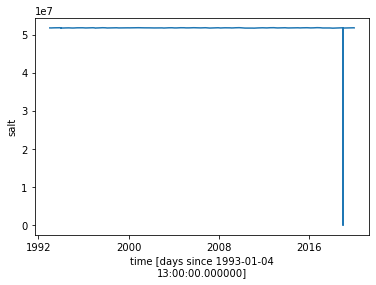

In [19]:
ds_wg.salt.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot()

In [17]:
mask = ds_wg.time != ds_wg.time.sel(time='2018-12-24').values
salt_mask = ds_wg.salt.where(mask)#.load()
temp_mask = ds_wg.temp.where(mask)#.load()

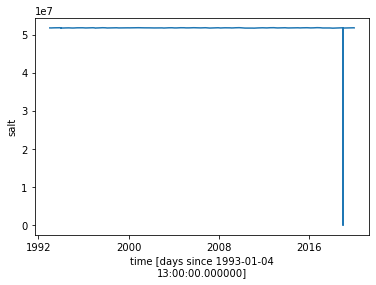

In [57]:
salt_mask.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot()
#still shows dip bc of .sum() but mask does work!

In [20]:
salt_mask.dtype

dtype('float32')

In [31]:
sigma2 = xr.apply_ufunc(jmd95numba.rho, ds_wg.salt.where(mask), ds_wg.temp.where(mask), pref,
                            output_dtypes=[ds_wg.salt.where(mask).dtype],
                            dask='parallelized').reset_coords(drop=True)#.load()

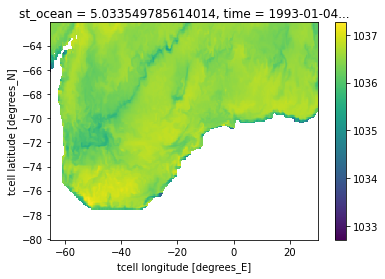

In [32]:
sigma2[0,0].plot()

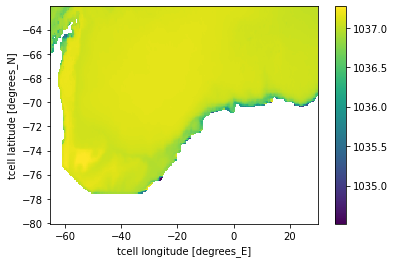

In [34]:
sigma2.mean(dim=['time', 'st_ocean']).plot()

In [35]:
sigma2.nbytes/1e9

50.738532

KeyboardInterrupt: 

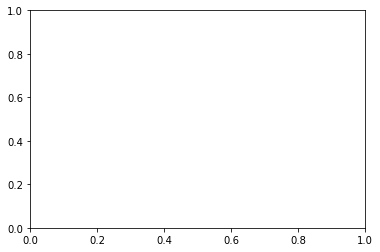

In [36]:
sigma2.mean(dim=['time', 'st_ocean']).plot.hist()

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_